In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from pathlib import Path

sns.set(style="whitegrid")
BASE_PATH = Path("../cache_new/optimization/")
DATASET_PATH = Path("../datasets/IDSSE/")
pio.renderers.default = "vscode"


In [11]:
def prepare_data():
    csv_files = list(BASE_PATH.rglob("*df_reduced.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        parts = file.parts[-6:]
        
        match_id = parts[0]
        step = parts[2]
        player = parts[1]
        method = parts[3]
        parameters = parts[4]

        df["game_id"] = match_id
        df["step"] = step
        df["player"] = player
        df["method"] = method
        df["parameters"] = parameters
        df["tuning"] = method + "-" + parameters

        dataframes.append(df)

    full_df = pd.concat(dataframes, ignore_index=True)
    full_df["DAS_potential_percentage"] = np.where(
        full_df["DAS_potential"] > 0,
        ((full_df["DAS"] - full_df["DAS_new"]) / full_df["DAS"]) * 100,
        0.0,
    )

    return full_df

def group_data(full_df):
    grouped_df = (
        full_df.groupby(["game_id", "player", "step", "method", "parameters", "tuning"]).agg(
            DAS_potential=("DAS_potential", "mean"),
            MAX_DAS_potential=("DAS_potential", "max"),
            SUM_DAS_potential=("DAS_potential", "sum"),
            DAS_potential_percentage=("DAS_potential_percentage", "mean"),
            distance=("distance", "mean"),
            count=("DAS_potential", "count")
        )
        .reset_index()
    )
    return grouped_df

def add_player_names():
    files = list(DATASET_PATH.rglob("*players.parquet"))
    dataframes = []
    
    for file in files:
        df = pd.read_parquet(file).copy()
        parts = file.parts
        game_id = parts[3]
        df["game_id"] = game_id
        df["team"] = "home" if "home_players" in parts[4] else "away"
        df["player"] = df['team'] + "_" + df['shirt_num'].astype(str)
        dataframes.append(df)
    
    all_players = pd.concat(dataframes, ignore_index=True)
    cols = ["game_id", "id", "full_name", "player"]
    return all_players[cols].drop_duplicates()
    
def compare_methods(fair_grouped_df):
    fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)
    
    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="DAS_potential_percentage",
                ax=axes[0]
    )
    axes[0].set_title("Boxplot DAS-Potential (%)")
    axes[0].set_ylabel("Verbesserung (%)")
    axes[0].set_xlabel("")
    axes[0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="DAS_potential",
                ax=axes[1]
    )
    axes[1].set_title("Boxplot DAS-Potential")
    axes[1].set_ylabel("Verbesserung")
    axes[1].set_xlabel("")
    axes[1].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    
    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="distance",
                ax=axes[2]
    )
    axes[2].set_title("Boxplot Distance")
    axes[2].set_ylabel("Verbesserung")
    axes[2].tick_params(axis="x", rotation=45)
    
    fig.suptitle("Vergleich der Methoden", fontsize=16)
    fig.tight_layout()
    plt.show()

def line_players(grouped_df, metric="DAS_potential"):
    df = grouped_df.copy()
    df["game_id"] = df["game_id"].astype(str)
    tunings = df["tuning"].unique()
    
    fig = go.Figure()
    trace_tuning = []
    for t in tunings:
        dft = df[df["tuning"] == t]
        for name, g in dft.groupby("full_name"):
            fig.add_trace(
                go.Scatter(
                    x=g["game_id"], y=g[metric],
                    mode="lines+markers",
                    name=name,
                    legendgroup=name,
                    showlegend=(t == tunings[0])
                )
            )
            trace_tuning.append(t)
    buttons = []
    for t in tunings:
        visible_mask = [tt == t for tt in trace_tuning]
        buttons.append(dict(
            label=t,
            method="update",
            args=[
                {"visible": visible_mask},
                {"title": f"DAS Potential pro Spiel (Tuning: {t})"}
            ]
        ))
    initial_mask = [tt == tunings[0] for tt in trace_tuning]
    fig.update_traces(visible=False)
    for i, vis in enumerate(initial_mask):
        fig.data[i].visible = vis
        
    # fig = px.line(
    #     grouped_df,
    #     x="game_id",
    #     y="DAS_potential",
    #     color="full_name",
    #     markers=True,
    #     title="DAS Potential pro Spiel"
    # )

    
    fig.update_layout(
        title=f"DAS Potential pro Spiel (Tuning: {tunings[0]})",
        xaxis_title="Spiel",
        yaxis_title=metric,
        legend_title="Spieler",
        updatemenus=[dict(
            type="dropdown",
            x=1.1,
            y=1.15,
            xanchor="left",
            buttons=buttons,
            active=0
        )]
    )
    fig.show()
    
def scatter_dist_pot(grouped_df):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=grouped_df, x="distance", y="DAS_potential_percentage", hue="method")
    plt.title("Zusammenhang: Entfernung vs. Potential")
    plt.xlabel("Entfernung (m)")
    plt.ylabel("DAS_potential_percentage (%)")
    plt.tight_layout()
    plt.show()
    
def facet_grid(grouped_df):
    g = sns.FacetGrid(
        data=grouped_df,
        col="game_id",
        hue="method",
        sharey=True,
        height=4,
        aspect=1.5
    )
    g.map(sns.barplot, "player", "DAS_potential_percentage", order=sorted(grouped_df["player"].unique()), errorbar=None)
    g.add_legend()
    g.set_titles(col_template="Match: {col_name}")
    g.set_axis_labels("Spieler", "Verbesserung (%)")
    for ax in g.axes.flat:
        ax.tick_params(axis="x", rotation=45)
        
    plt.tight_layout()
    plt.show()
    

In [12]:
full_df = prepare_data()
full_df.to_csv("output/full_das.csv", index=False)
grouped_df = group_data(full_df)
grouped_df.to_csv("output/grouped_das.csv", index=False)

display(full_df.head())
display(grouped_df.head())
# display("Values By Step")
# display(full_df["step"].value_counts())
# => Aktuell nur 125 Ergebnisse

# display("Values By Game")
# display(full_df.value_counts(["game_id", "player", "tuning"]))

,player_id,frame,DAS,DAS_new,new_frame,DAS_potential,move_x,move_y,distance,game_id,step,player,method,parameters,tuning,DAS_potential_percentage
0,home_19,160412,0.244021,0.230110,160412_home_19_0.00_1.00,0.013911,0.0,1.0,1.000000,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,5.700618
1,home_19,160728,0.591525,0.292932,160728_home_19_-3.00_0.00,0.298593,-3.0,0.0,3.000000,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,50.478550
2,home_19,160887,1.964608,1.903491,160887_home_19_-3.00_4.00,0.061117,-3.0,4.0,5.000000,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,3.110894
3,home_19,164080,0.020754,0.020737,164080_home_19_-3.00_1.00,0.000017,-3.0,1.0,3.162278,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.080708
4,home_19,164747,0.140323,0.140466,164747_home_19_-2.00_-1.00,0.000000,-2.0,-1.0,2.236068,J03WOH,step125,home_19,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.000000


,game_id,player,step,method,parameters,tuning,DAS_potential,MAX_DAS_potential,SUM_DAS_potential,DAS_potential_percentage,distance,count
0,J03WOH,away_1,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.206628,5.312502,32.440526,2.132421,4.433721,157
1,J03WOH,away_1,step125,random,R_5-S_1-D_2-N_50,random-R_5-S_1-D_2-N_50,0.214298,5.312502,33.644801,2.320122,4.760747,157
2,J03WOH,away_10,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.130482,0.907313,0.913376,14.667395,4.148986,7
3,J03WOH,away_10,step125,random,R_5-S_1-D_2-N_50,random-R_5-S_1-D_2-N_50,0.001438,0.003341,0.010068,8.114311,3.754956,7
4,J03WOH,away_11,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.134318,4.006298,21.087951,6.748207,4.260586,157


In [5]:
# Übersicht vorhandene databallpy_event
pivot = full_df.groupby(["game_id", "tuning"])["player"].nunique().unstack(fill_value=0).reset_index()

pivot

tuning,game_id,all_positions-R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_100,random-R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_50
0,J03WOH,1,0,32,32
1,J03WOY,1,1,32,32
2,J03WPY,1,1,31,27
3,J03WQQ,1,0,31,1
4,J03WR9,1,1,30,1


Anzahl verschiedener Parameterkombinationen: 4


'Vollständige Kombinationen: 3'

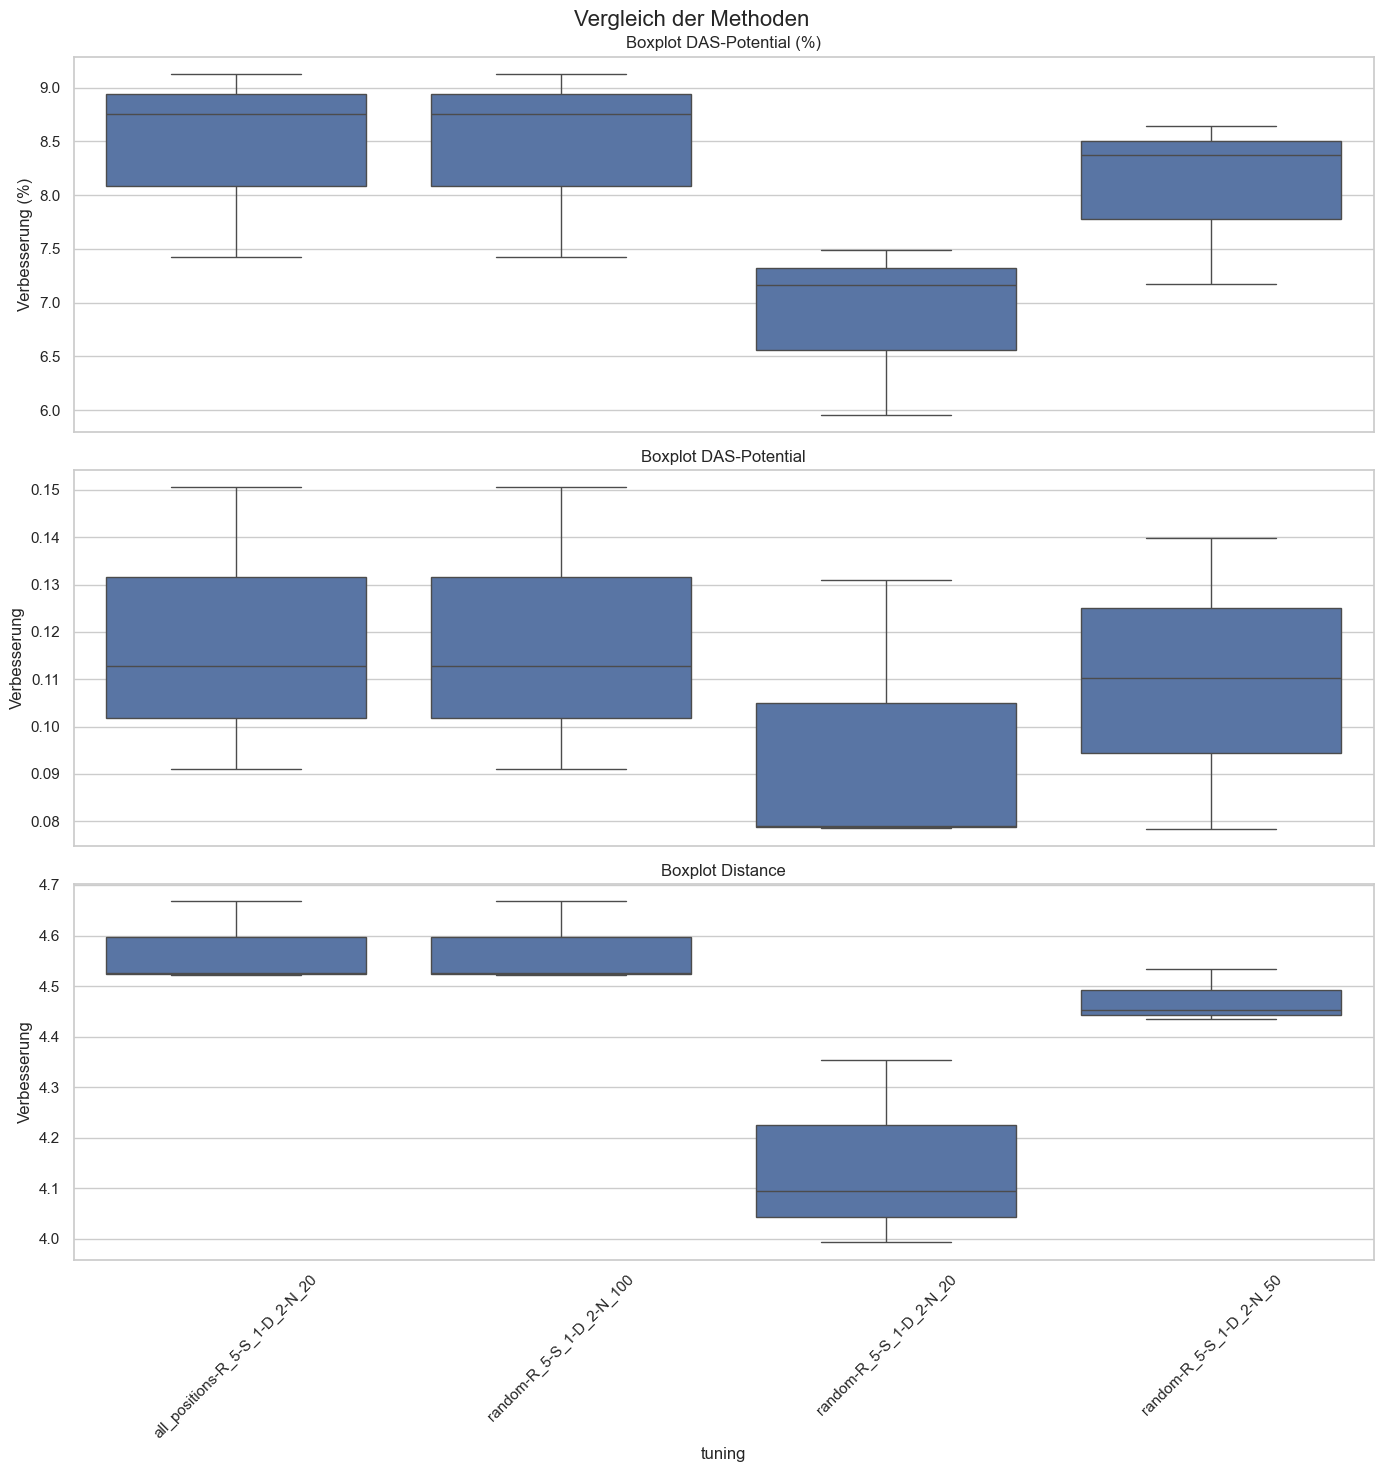

In [6]:
# Fairer Vergleich Methoden / Parameter
n_total_params = grouped_df["tuning"].nunique()
print(f"Anzahl verschiedener Parameterkombinationen: {n_total_params}")

param_counts = (
    grouped_df.groupby(["game_id", "player"])["tuning"]
    .nunique()
    .reset_index(name="param_count")
)
complete_combinations = param_counts[param_counts["param_count"] == n_total_params]
display(f"Vollständige Kombinationen: {len(complete_combinations)}")

fair_grouped_df = grouped_df.merge(complete_combinations, on=["game_id", "player"])

compare_methods(fair_grouped_df)



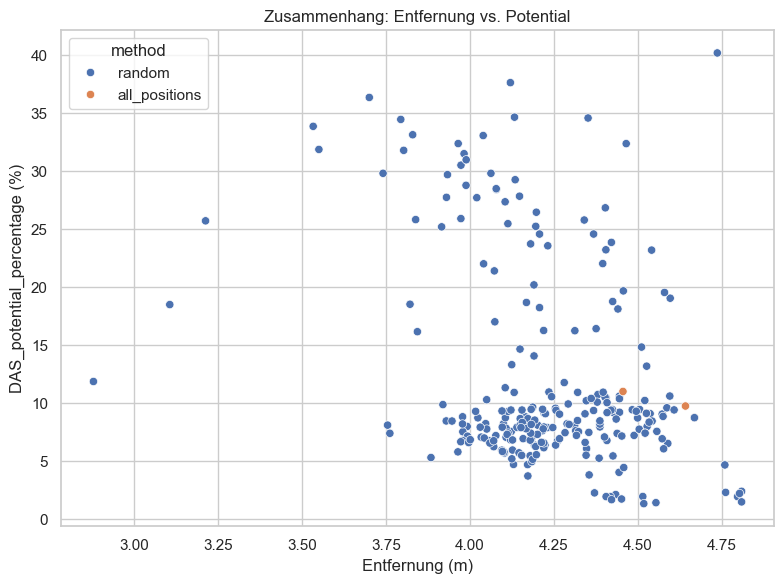

In [7]:
scatter_dist_pot(grouped_df)



In [8]:
# Spieler für alle Spiele
n_total_games = grouped_df["game_id"].nunique()
print(f"Anzahl Spiele: {n_total_games}")

all_players = add_player_names()
grouped_named = grouped_df.merge(all_players, on=["game_id", "player"], how="left")

games_played = grouped_named.groupby("id")["game_id"].nunique().reset_index(name="games_played")
all_game_players = games_played[games_played["games_played"] == n_total_games]

fair_grouped_df = grouped_named.merge(all_game_players, on="id")

line_players(fair_grouped_df)

Anzahl Spiele: 5


In [9]:
full_df_das_g1 = full_df[full_df["DAS"] > 1]
grouped_df_das_g1 = group_data(full_df_das_g1)

grouped_named_das_g1 = grouped_df_das_g1.merge(all_players, on=["game_id", "player"], how="left")
fair_grouped_das_g1 = grouped_named_das_g1.merge(all_game_players, on="id")

line_players(fair_grouped_das_g1)
line_players(fair_grouped_das_g1, metric="MAX_DAS_potential")


In [10]:
display(fair_grouped_df)
display(fair_grouped_das_g1)

,game_id,player,step,method,parameters,tuning,DAS_potential,MAX_DAS_potential,SUM_DAS_potential,DAS_potential_percentage,distance,count,id,full_name,games_played
0,J03WOH,home_11,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.061156,1.031620,7.461061,7.547305,3.978846,122,DFL-OBJ-0000F8,Felix Klaus,5
1,J03WOH,home_11,step125,random,R_5-S_1-D_2-N_50,random-R_5-S_1-D_2-N_50,0.073226,1.178691,8.933544,8.510028,4.320047,122,DFL-OBJ-0000F8,Felix Klaus,5
2,J03WOH,home_19,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.074728,0.298593,0.373638,11.874154,2.879669,5,DFL-OBJ-0026RH,Emmanuel Iyoha,5
3,J03WOH,home_19,step125,random,R_5-S_1-D_2-N_50,random-R_5-S_1-D_2-N_50,0.291772,1.338520,1.458859,29.259300,4.134586,5,DFL-OBJ-0026RH,Emmanuel Iyoha,5
4,J03WOH,home_23,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.019916,0.109951,0.517819,8.241985,4.046814,26,DFL-OBJ-002G5J,Shinta Karl Appelkamp,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,J03WR9,home_25,step125,random,R_5-S_1-D_2-N_50,random-R_5-S_1-D_2-N_50,0.078425,1.583659,10.508944,8.372633,4.533169,134,DFL-OBJ-0000NZ,Matthias Jürgen Zimmermann,5
70,J03WR9,home_33,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.068222,3.113097,9.141708,1.691647,4.421332,134,DFL-OBJ-0028FW,Florian Kastenmeier,5
71,J03WR9,home_5,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.114993,4.785211,15.409000,10.566591,4.243077,134,DFL-OBJ-002GM9,Christoph Klarer,5
72,J03WR9,home_7,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.610084,13.915432,73.210046,28.485651,4.078140,120,DFL-OBJ-002GM1,Kristoffer Paul Peterson,5


,game_id,player,step,method,parameters,tuning,DAS_potential,MAX_DAS_potential,SUM_DAS_potential,DAS_potential_percentage,distance,count,id,full_name,games_played
0,J03WOH,home_11,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.156900,1.031620,6.432907,5.103355,4.189764,41,DFL-OBJ-0000F8,Felix Klaus,5
1,J03WOH,home_11,step125,random,R_5-S_1-D_2-N_50,random-R_5-S_1-D_2-N_50,0.189016,1.178691,7.749643,6.368056,4.444800,41,DFL-OBJ-0000F8,Felix Klaus,5
2,J03WOH,home_19,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.061117,0.061117,0.061117,3.110894,5.000000,1,DFL-OBJ-0026RH,Emmanuel Iyoha,5
3,J03WOH,home_19,step125,random,R_5-S_1-D_2-N_50,random-R_5-S_1-D_2-N_50,1.338520,1.338520,1.338520,68.131666,4.472136,1,DFL-OBJ-0026RH,Emmanuel Iyoha,5
4,J03WOH,home_23,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.035731,0.086892,0.250116,1.135348,4.016160,7,DFL-OBJ-002G5J,Shinta Karl Appelkamp,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,J03WR9,home_25,step125,random,R_5-S_1-D_2-N_50,random-R_5-S_1-D_2-N_50,0.417255,1.583659,9.596873,11.194510,3.989914,23,DFL-OBJ-0000NZ,Matthias Jürgen Zimmermann,5
70,J03WR9,home_33,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.385120,3.113097,8.857764,3.813694,4.471042,23,DFL-OBJ-0028FW,Florian Kastenmeier,5
71,J03WR9,home_5,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,0.626257,4.785211,14.403920,11.761031,3.585171,23,DFL-OBJ-002GM9,Christoph Klarer,5
72,J03WR9,home_7,step125,random,R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,3.457833,13.915432,69.156656,55.298117,4.096463,20,DFL-OBJ-002GM1,Kristoffer Paul Peterson,5
